## Imports

In [76]:
import os
import glob
import functools

from clu import metric_writers
import jax
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import optax
import orbax.checkpoint as ocp
import tensorflow as tf
import tensorflow_datasets as tfds

from swirl_dynamics import templates
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn

## Conditional diffusion model

In the above example, we trained an *unconditional* diffusion model and applied conditioning at inference time. This is not always easy to do, depending on how the conditioning input relates to the samples.

Alternatively, we can directly *train a conditional model*, where the conditional signal is provided at training time as an additional input to the denoising neural network, which may then use it to compute the denoised target.

Below we show an example of how to accomplish this. We again generate samples of handwritten digits, using the MNIST dataset for training. We will condition the generation on the `x[11:18, 11:18]` patch.

### Dataset

Besides the sample in `x`, the dataset for training conditional models require a `cond` key which contains the condition signals.

In [51]:
# from generator method
def load_nc_dir_with_generator(dir_: str, split: str):
    def gen():
        for file in glob.glob(os.path.join(dir_, f"{split}/*.zarr")):
            ds = xr.open_zarr(file)
            yield {key: tf.convert_to_tensor(val) for key, val in ds.items()}

    sample = next(iter(gen()))

    return tf.data.Dataset.from_generator(
        gen,
        output_signature={
            key: tf.TensorSpec(val.shape, dtype=val.dtype)
            for key, val in sample.items()
        }
    )

def preproc_ecmwf(example: dict[str, tf.Tensor]):
    processed = {}
    mean_chirps, var_chirps = tf.nn.moments(example["chirps"], axes=[0, 1, 2])
    processed["x"] = tf.cast((example["chirps"] - mean_chirps) / (var_chirps + 1e-4), tf.float32) 
    
    # The "channel:" prefix indicate that the conditioning signal is to be
    # incorporated by resizing and concatenating along the channel dimension.
    # This is implemented at the backbone level.
    mean_ecmwf, var_ecmwf = tf.nn.moments(example["ecmwf"], axes=[0, 1, 2])
    processed["cond"] = {"channel:low_res": tf.cast((example["ecmwf"]- mean_ecmwf) / (var_ecmwf + 1e-4), tf.float32)}
    return processed

def get_cond_ecmwf_dataset(split: str, batch_size: int):
    ds = load_nc_dir_with_generator("data/", split)
    ds = ds.map(preproc_ecmwf)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds = ds.as_numpy_iterator()
    return ds

def get_mean_std_data(split: str):
    ds = xr.open_mfdataset(f"data/{split}/*.zarr", engine='zarr')
    mean_chirps, mean_ecmwf = float(ds.mean().chirps.load().values), float(ds.mean().ecmwf.load().values)
    var_chirps, var_ecmwf = float(ds.std().chirps.load().values), float(ds.std().ecmwf.load().values)
    return mean_chirps, var_chirps, mean_ecmwf, var_ecmwf

DATA_STD = 0.31

In [41]:
for array in get_cond_ecmwf_dataset(split="test", batch_size=4):
    print(array['x'].shape)
    print(array['cond']["channel:low_res"].shape)
    break

(4, 28, 28, 1)
(4, 28, 28, 1)


### Architecture

The architecture is similar to the unconditional case. We provide additional args that specify how to resize the conditioning signal (in order to be compatible with the noisy sample for channel-wise concatenation).

In [56]:
cond_denoiser_model = dfn_lib.PreconditionedDenoiser(
    out_channels=1,
    num_channels=(64, 128),
    downsample_ratio=(2, 2),
    num_blocks=4,
    noise_embed_dim=128,
    padding="SAME",
    use_attention=True,
    use_position_encoding=True,
    num_heads=8,
    sigma_data=DATA_STD,
    cond_resize_method="cubic",
    cond_embed_dim=128,
)

### Training

The `DenoisingModel` is again similar to the unconditional case. We additionally provide the shape information of the `cond` input.

In [57]:
diffusion_scheme = dfn_lib.Diffusion.create_variance_exploding(
    sigma=dfn_lib.tangent_noise_schedule(),
    data_std=DATA_STD,
)

cond_model = dfn.DenoisingModel(
    input_shape=(28, 28, 1),
    # `cond_shape` must agree with the expected structure and shape
    # (without the batch dimension) of the `cond` input.
    cond_shape={"channel:low_res": (28, 28, 1)},
    denoiser=cond_denoiser_model,
    noise_sampling=dfn_lib.log_uniform_sampling(
        diffusion_scheme, clip_min=1e-4, uniform_grid=True,
    ),
    noise_weighting=dfn_lib.edm_weighting(data_std=DATA_STD),
)

The rest mostly repeats the unconditional training example, replacing the datasets and model with their conditional counterparts.

In [58]:
# !rm -R -f $cond_workdir  # optional: clear the working directory

In [59]:
num_train_steps = 100000  #@param
cond_workdir = "/home/u/amine.barkaoui/chkpts/cond_diffusion_ecmwf_50000"  # "/tmp/cond_diffusion_demo_mnist"  #@param
train_batch_size = 32  #@param
eval_batch_size = 32  #@param
initial_lr = 0.0  #@param
peak_lr = 1e-4  #@param
warmup_steps = 1000  #@param
end_lr = 1e-6  #@param
ema_decay = 0.999  #@param
ckpt_interval = 1000  #@param
max_ckpt_to_keep = 5  #@param

In [ ]:
cond_trainer = dfn.DenoisingTrainer(
    model=cond_model,
    rng=jax.random.PRNGKey(888),
    optimizer=optax.adam(
        learning_rate=optax.warmup_cosine_decay_schedule(
            init_value=initial_lr,
            peak_value=peak_lr,
            warmup_steps=warmup_steps,
            decay_steps=num_train_steps,
            end_value=end_lr,
        ),
    ),
    ema_decay=ema_decay,
)

templates.run_train(
    train_dataloader=get_cond_ecmwf_dataset(
        split="train", batch_size=train_batch_size
    ),
    trainer=cond_trainer,
    workdir=cond_workdir,
    total_train_steps=num_train_steps,
    metric_writer=metric_writers.create_default_writer(
        cond_workdir, asynchronous=False
    ),
    metric_aggregation_steps=100,
    eval_dataloader=get_cond_ecmwf_dataset(
        split="train", batch_size=eval_batch_size
    ),
    eval_every_steps = 1000,
    num_batches_per_eval = 2,
    callbacks=(
        templates.TqdmProgressBar(
            total_train_steps=num_train_steps,
            train_monitors=("train_loss",),
        ),
        templates.TrainStateCheckpoint(
            base_dir=cond_workdir,
            options=ocp.CheckpointManagerOptions(
                save_interval_steps=ckpt_interval, max_to_keep=max_ckpt_to_keep
            ),
        ),
    ),
)

2024-03-04 13:28:50.281541: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
 99%|█████████▉| 99300/100000 [9:36:52<03:29,  3.34step/s, train_loss=0.9185231]   

### Inference

To perform inference/sampling, let's load back the trained conditional model checkpoint:

In [60]:
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f"{cond_workdir}/checkpoints", step=None
)
# Construct the inference function
cond_denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=cond_denoiser_model
)

2024-03-05 18:12:29.393229: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


The conditional sampler again follows the previous example, with the only exception being that the conditional model replaces the unconditional one.

Below we do not apply any guidance, but one can be easily added in the same way as in the unconditional example above.

In [61]:
cond_sampler = dfn_lib.SdeSampler(
    input_shape=(28, 28, 1),
    integrator=solver_lib.EulerMaruyama(),
    tspan=dfn_lib.edm_noise_decay(
        diffusion_scheme, rho=7, num_steps=256, end_sigma=1e-3,
    ),
    scheme=diffusion_scheme,
    denoise_fn=cond_denoise_fn,
    guidance_transforms=(),
    apply_denoise_at_end=True,
    return_full_paths=False,
)

We again JIT the generate function for the sake of faster repeated sampling calls. Here we employ `functools.partial` to specify `num_samples=5`, making it easier to vectorize across the batch dimension with `jax.vmap`.

In [62]:
num_samples_per_cond = 5

generate = jax.jit(
    functools.partial(cond_sampler.generate, num_samples_per_cond)
)

Loading a test batch of conditions with 4 elements:

In [63]:
batch_size = 4
test_ds = next(iter(get_cond_ecmwf_dataset(split="test", batch_size=4)))
test_batch_cond = test_ds["cond"]
test_batch_gt = test_ds["x"]

In [64]:
mean_chirps, var_chirps, mean_ecmwf, var_ecmwf = get_mean_std_data(split="test")

The vectorized generate function is applied to the loaded batch. The vectorization occurs for the leading dimensions of both the random seed and the condition (for those unfamiliarized with vectorized operations in jax, think of a more efficient `for` loop that iterates over the random seeds and batch conditions zipped together).

In [65]:
cond_samples = jax.vmap(generate, in_axes=(0, 0, None))(
    jax.random.split(jax.random.PRNGKey(8888), batch_size),
    test_batch_cond,
    None,  # Guidance inputs = None since no guidance transforms involved
)

The result `cond_samples` has shape `(batch_size, num_samples_per_cond, *input_shape)`.

In [66]:
print(cond_samples.shape)

(4, 5, 28, 28, 1)


Visualize generated examples alongside their low-res conditioning:

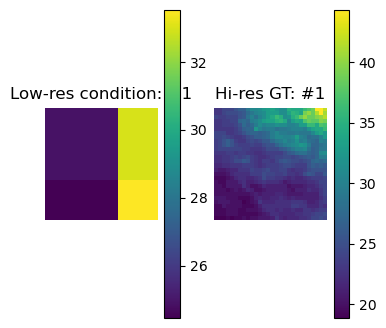

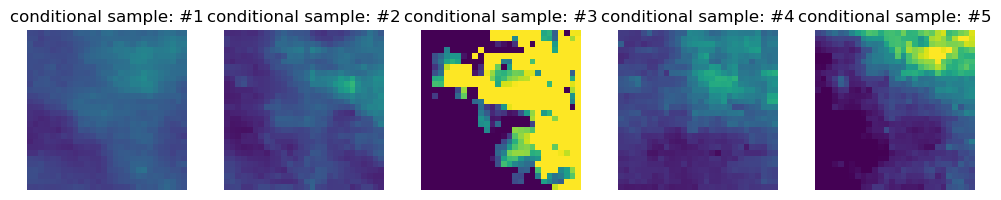

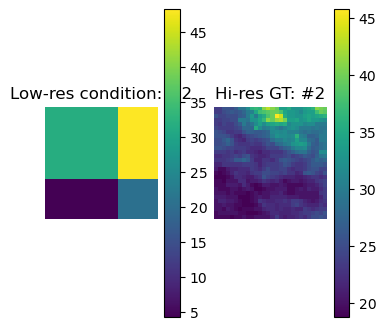

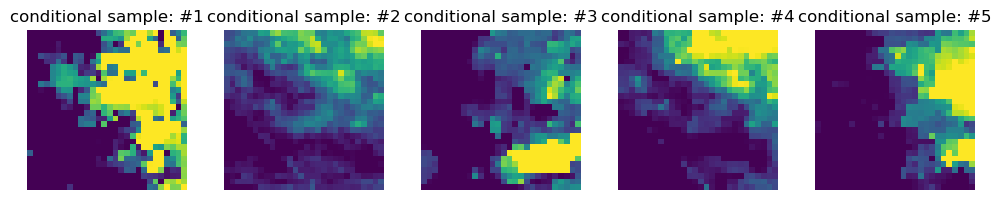

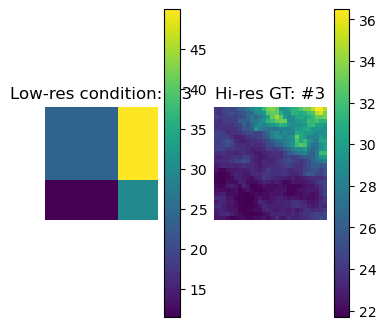

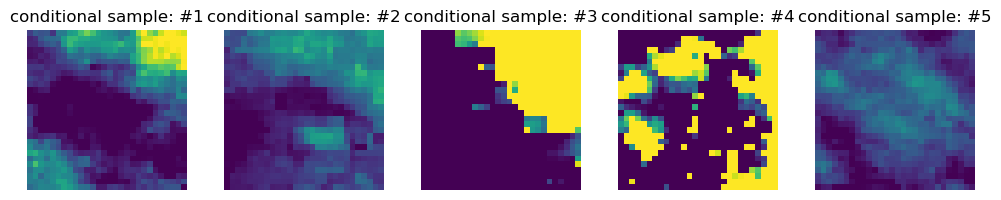

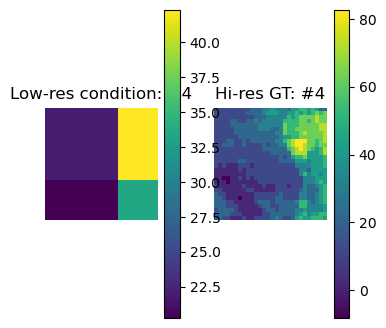

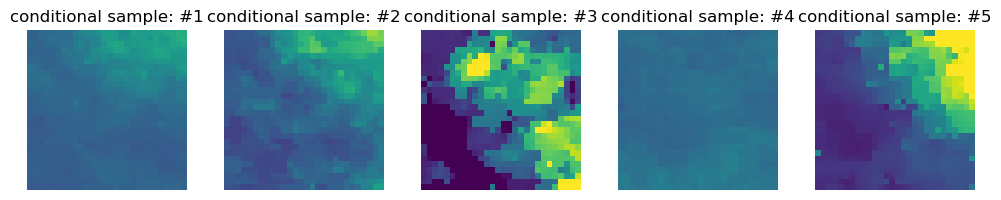

In [79]:
for i in range(batch_size):
    fig, ax = plt.subplots(1, 2, figsize=(4, 4))
    im = ax[0].imshow(
        test_batch_cond["channel:low_res"][i, :, :, 0] * (var_ecmwf + 1e-4) + mean_ecmwf,
        cmap="viridis",
    )
    ax[0].axis("off")
    ax[0].set_title(f"Low-res condition: #{i + 1}")
    
    fig.colorbar(im, ax=ax[0])
    
    im = ax[1].imshow(
        test_batch_gt[i, :, :, 0]  * (var_chirps + 1e-4) + mean_chirps,
        cmap="viridis",
    )
    ax[1].axis("off")
    ax[1].set_title(f"Hi-res GT: #{i + 1}")
    
    fig.colorbar(im, ax=ax[1])
    
    min_hi_res = np.min(test_batch_gt[i, :, :, 0]  * (var_chirps + 1e-4) + mean_chirps)
    max_hi_res = np.max(test_batch_gt[i, :, :, 0]  * (var_chirps + 1e-4) + mean_chirps)

    # Plot generated samples.
    fig, ax = plt.subplots(
        1, num_samples_per_cond, figsize=(num_samples_per_cond * 2, 2)
    )
    for j in range(num_samples_per_cond):
        if num_samples_per_cond == 1:
            im = ax.imshow(
                cond_samples[i, j, :, :, 0] * (var_chirps + 1e-4) + mean_chirps, 
                cmap="viridis", 
                vmin=min_hi_res,
                vmax=max_hi_res,
            )
            ax.set_title(f"conditional sample: #{j + 1}")
            ax.axis("off")
        else:
            im = ax[j].imshow(
                cond_samples[i, j, :, :, 0] * (var_chirps + 1e-4) + mean_chirps, 
                cmap="viridis",
                vmin=min_hi_res,
                vmax=max_hi_res,
            )
            ax[j].set_title(f"conditional sample: #{j + 1}")
            ax[j].axis("off")
    plt.tight_layout()

plt.show()